# Examining LAMOST Kepler Gaia crossmatch.

The version of this code used in the paper is implemented in code/data.py.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Merge Gaia and LAMOST catalogs using RA and dec. Merge Gaia and APOGEE using source_id.

In [9]:
def load_and_merge_data():
    # Load Gaia-Kepler crossmatch.
    with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
        gaia = pd.DataFrame(data[1].data, dtype="float64")
    m = gaia.parallax.values > 0
    gaia = gaia.iloc[m]

    # Round RVs down to 6dp.
    gaia["ra_6dp"] = np.round(gaia.ra.values, 6)
    gaia["dec_6dp"] = np.round(gaia.dec.values, 6)

    # Add LAMOST
    # File created using the LAMOST DR5 website: http://dr5.lamost.org/search
    lamost = pd.read_csv("../data/gaia-kepler-lamost_snr.csv")

    # Remove one star with a giant LAMOST RV errorbar
    m = abs(lamost.stellar_rv_err.values) < 100
    lamost = lamost.iloc[m]

    # Merge Gaia and LAMOST on (rounded) RA and dec
    lamost["ra_6dp"] = lamost.inputobjs_input_ra.values
    lamost["dec_6dp"] = lamost.inputobjs_input_dec.values
    lamost_gaia = pd.merge(gaia, lamost, on=["ra_6dp", "dec_6dp"],
                           how="left", suffixes=["", "_lamost"])
    lamost_gaia = lamost_gaia.drop_duplicates(subset="source_id")

    # Load apogee
    tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
    names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
    apo = tbl[names].to_pandas()

    apodf = pd.merge(apo, lamost_gaia, how="right", left_on="GAIA_SOURCE_ID",
                     right_on="source_id", suffixes=["_apogee", ""])
    apodf = apodf.drop_duplicates(subset="source_id")
    return apodf

In [161]:
def fit_line(x, y, yerr):
    AT = np.vstack((np.ones(len(x)), x))
    C = np.eye(len(x))*yerr
    CA = np.linalg.solve(C, AT.T)
    Cy = np.linalg.solve(C, y)
    ATCA = np.dot(AT, CA)
    ATCy = np.dot(AT, Cy)
    w = np.linalg.solve(ATCA, ATCy)

    cov = np.linalg.inv(ATCA)
    sig = np.sqrt(np.diag(cov))
    return w, sig

def combine_rv_measurements(df):
    """
    Combine RVs from LAMOST, Gaia, and APOGEE into one column,

    LAMOST RVs are overwritten by Gaia RVs, which are overwritten by APOGEE
    RVS.
    LAMOST RVs are called 'stellar_rv, stellar_rv_err',
    Gaia are called 'radial_velocity, radial_velocity_error',
    APOGEE are called 'OBSVHELIO_AVG, OBSVERR'.
    """

    rv, rv_err = [np.ones(len(df))*np.nan for i in range(2)]
    
    ml = np.isfinite(df.stellar_rv.values)
    mg = np.isfinite(df.radial_velocity.values) & (df.radial_velocity.values != 0)
    ma = np.isfinite(df.OBSVHELIO_AVG.values)
    mlmgma = ml & mg & ma
    mlmg = ml & mg
    mamg = ma & mg

    # Correct LAMOST RVs
    x, y = df.radial_velocity.values[mlmg], df.stellar_rv.values[mlmg]-df.radial_velocity.values[mlmg]
    yerr = df.stellar_rv_err.values[mlmg]
    w, sig = fit_line(x, y, yerr)
    lamost_corrected = df.stellar_rv.values - (w[0] + w[1]*df.stellar_rv.values)
    df["lamost_corrected_rv"] = lamost_corrected

    rv[ml] = lamost_corrected[ml]
    rv_err[ml] = df.stellar_rv_err.values[ml]
    print(sum(ml), "stars with LAMOST RVs")

    # Overwrite LAMOST RVs with Gaia RVs
    rv[mg] = df.radial_velocity.values[mg]
    rv_err[mg] = df.radial_velocity_error.values[mg]
    print(sum(mg), "stars with Gaia RVs")

    # Correct APOGEE RVs
    # remove outliers
    tot_err = np.sqrt(df.radial_velocity_error.values[mamg]**2 + df.OBSVERR.values[mamg]**2)
    ro = abs(df.OBSVHELIO_AVG.values[mamg] - df.radial_velocity.values[mamg]) < 3 * tot_err
    
    x, y = df.radial_velocity.values[mamg], df.OBSVHELIO_AVG.values[mamg]-df.radial_velocity.values[mamg]
    yerr = df.OBSVERR.values[mamg]
    w, sig = fit_line(x, y, yerr)
    apogee_corrected = df.OBSVHELIO_AVG.values - (w[0] + w[1]*df.OBSVHELIO_AVG.values)
    df["apogee_corrected_rv"] = apogee_corrected
    
    # Overwrite Gaia RVs with APOGEE RVs
    rv[ma] = apogee_corrected[ma]
    rv_err[ma] = df.OBSVERR.values[ma]
    print(sum(ma), "stars with APOGEE RVs")

    print(sum(np.isfinite(rv)), "stars with RVs")
    print(sum(mlmg), "with LAMOST and Gaia")
    print(sum(mlmgma), "with all three")

    df["rv"] = rv
    df["rv_err"] = rv_err
    return df

In [162]:
df0 = load_and_merge_data()
df = combine_rv_measurements(df0)

39577 stars with LAMOST RVs
30179 stars with Gaia RVs
11052 stars with APOGEE RVs
58402 stars with RVs
12917 with LAMOST and Gaia
3726 with all three


Text(0, 0.5, 'dec')

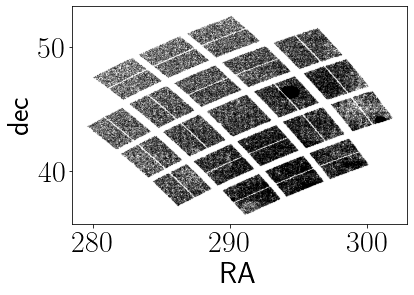

In [163]:
plt.plot(df.ra, df.dec, "k.", ms=.1, rasterized=True)
plt.xlabel("RA")
plt.ylabel("dec")

In [164]:
ml = np.isfinite(df.stellar_rv.values)
mg = np.isfinite(df.radial_velocity.values) & (df.radial_velocity.values != 0)
ma = np.isfinite(df.OBSVHELIO_AVG.values)
mlmgma = ml & mg & ma
mlmg = ml & mg
mamg = ma & mg

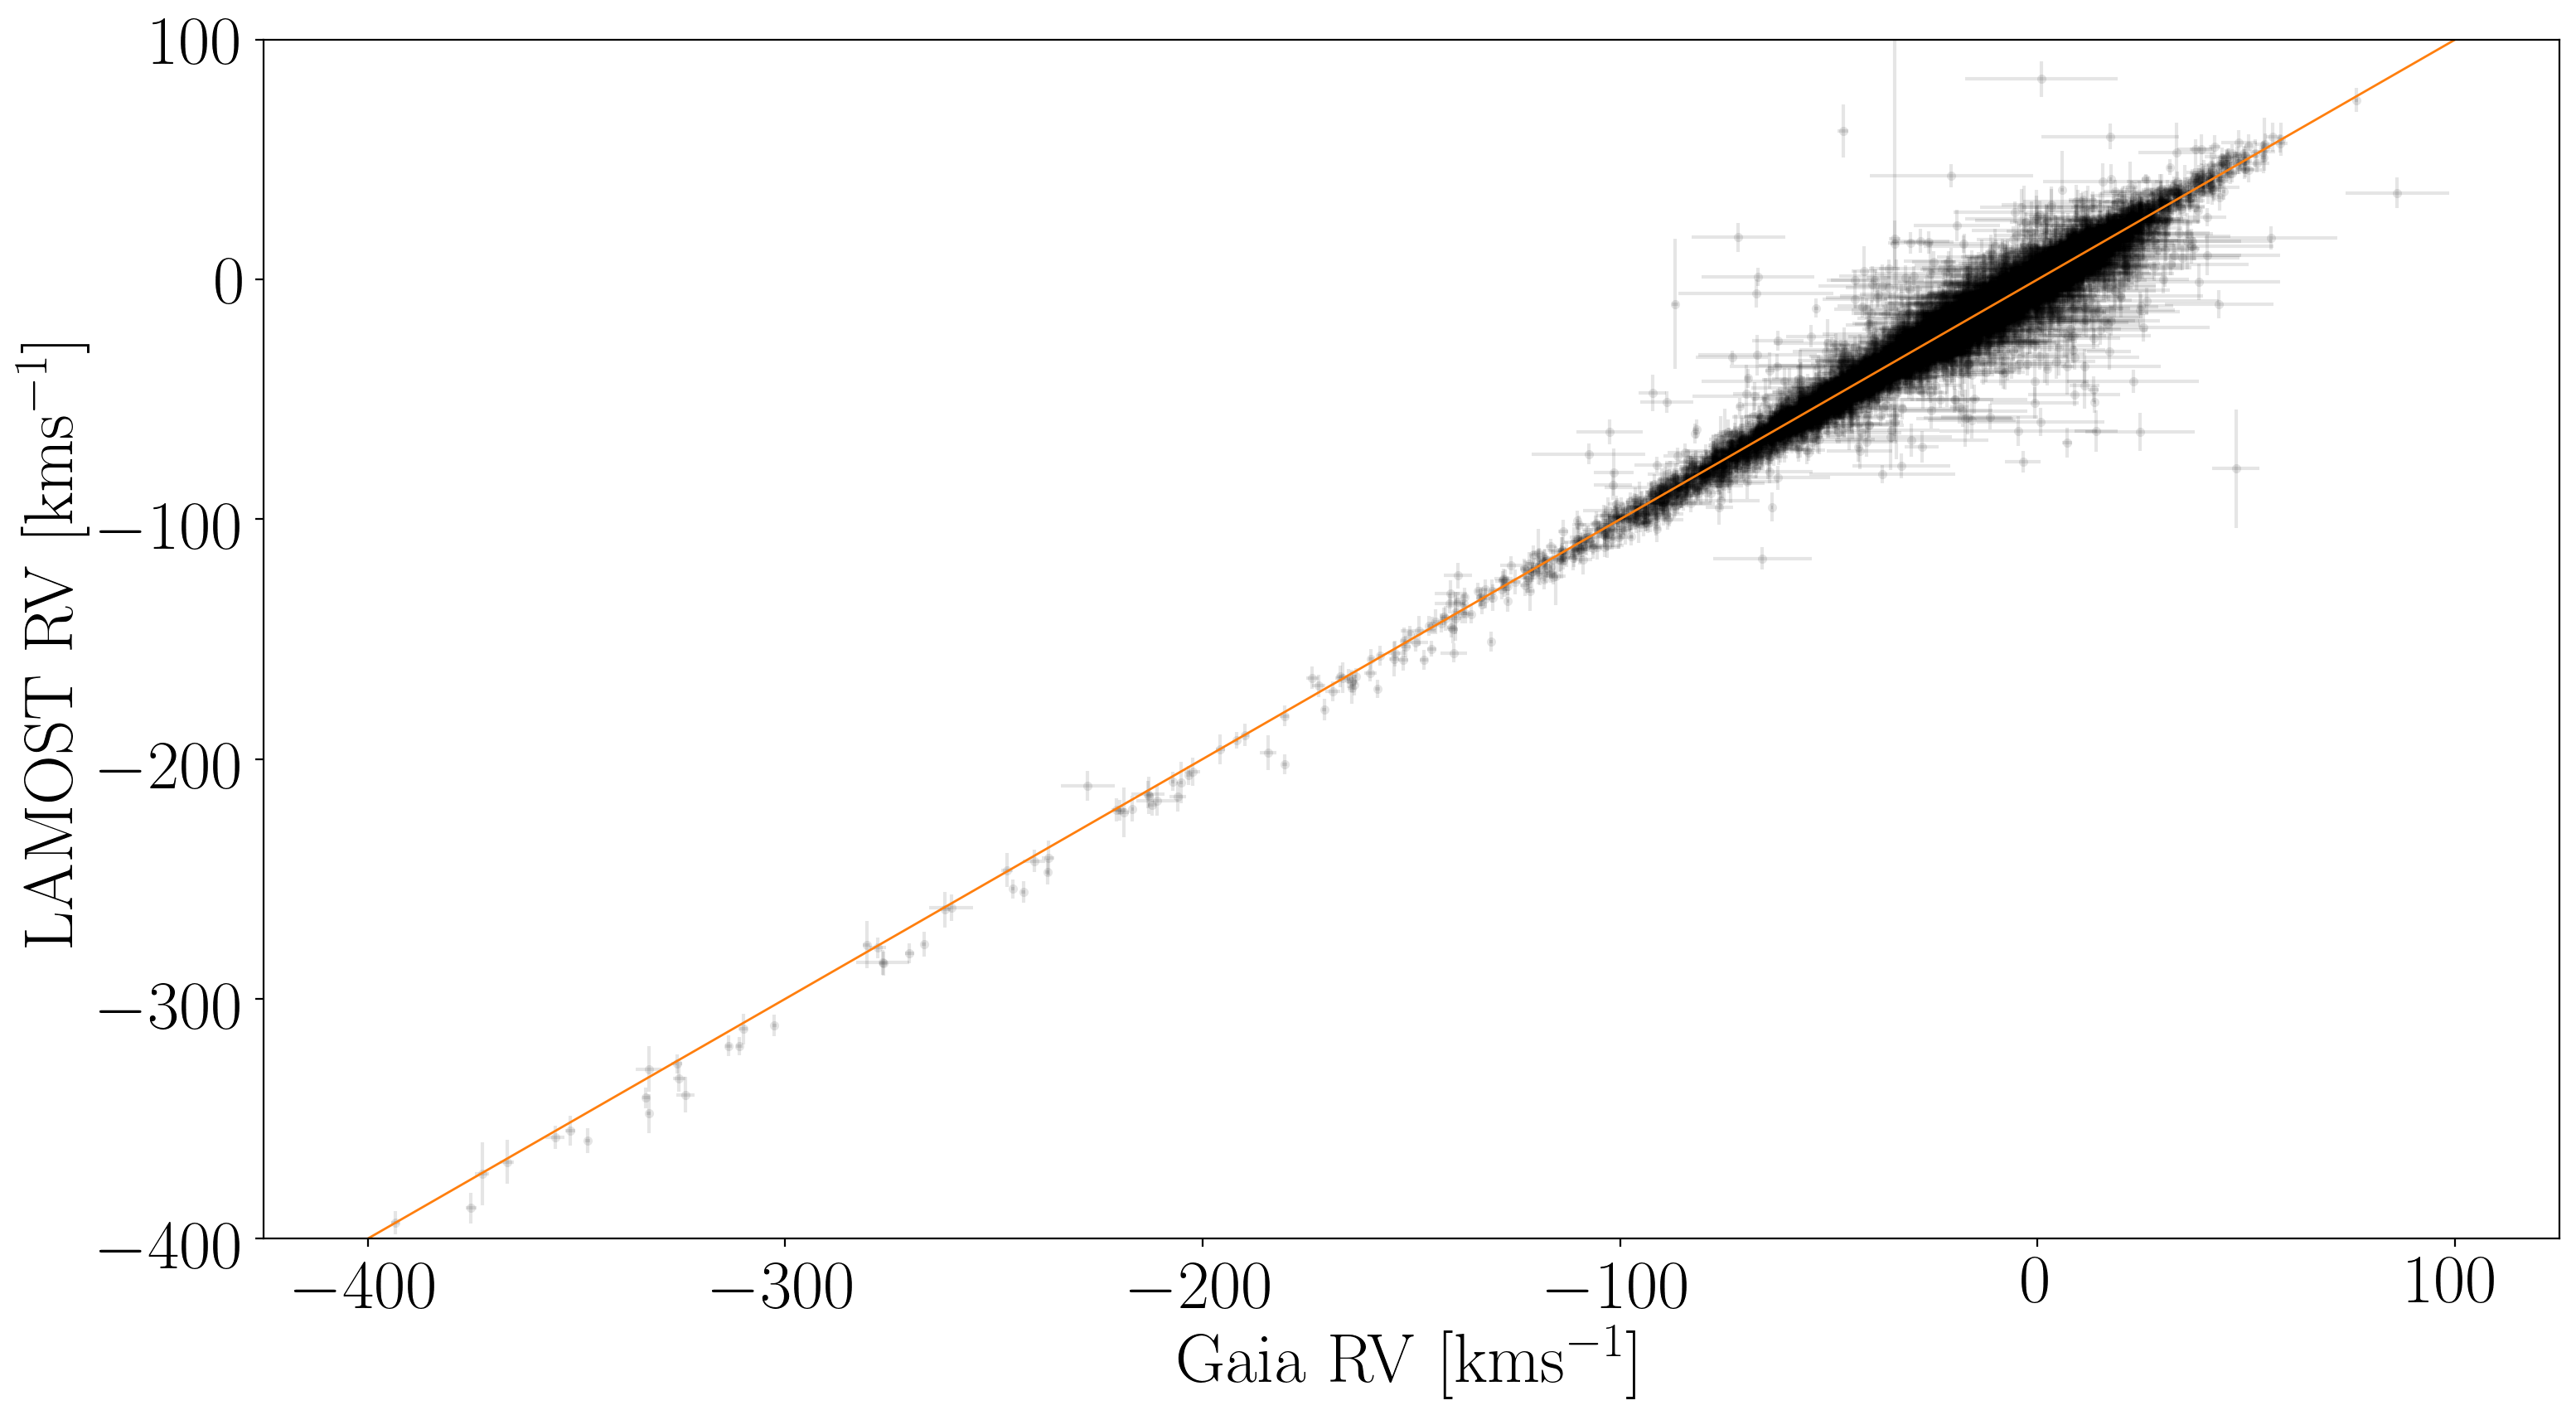

In [165]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.radial_velocity.values[mlmg], df.lamost_corrected_rv[mlmg],
             xerr=df.radial_velocity_error.values[mlmg],
             yerr=df.stellar_rv_err.values[mlmg],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.xlabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.ylabel("$\mathrm{LAMOST~RV~[km s^{-1}]}$")
plt.tight_layout()

Plot a histogram of the residuals.

1.060188110709007 0.00916780890288439
1.087090915219484 1.2334411412746231


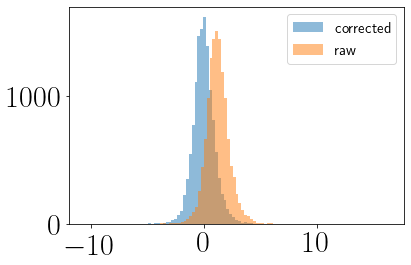

In [166]:
tot_err = np.sqrt(df.radial_velocity_error.values[mlmg]**2 + df.stellar_rv_err.values[mlmg]**2)
resids = df.radial_velocity.values[mlmg] - df.lamost_corrected_rv.values[mlmg]
plt.hist(resids/tot_err, 100, alpha=.5, label="corrected");
print(np.std(resids/tot_err), np.mean(resids/tot_err))

resids2 = df.radial_velocity.values[mlmg] - df.stellar_rv.values[mlmg]
plt.hist(resids2/tot_err, 100, alpha=.5, label="raw");
print(np.std(resids2/tot_err), np.mean(resids2/tot_err))

plt.legend()

Now look at the APOGEE RVs.

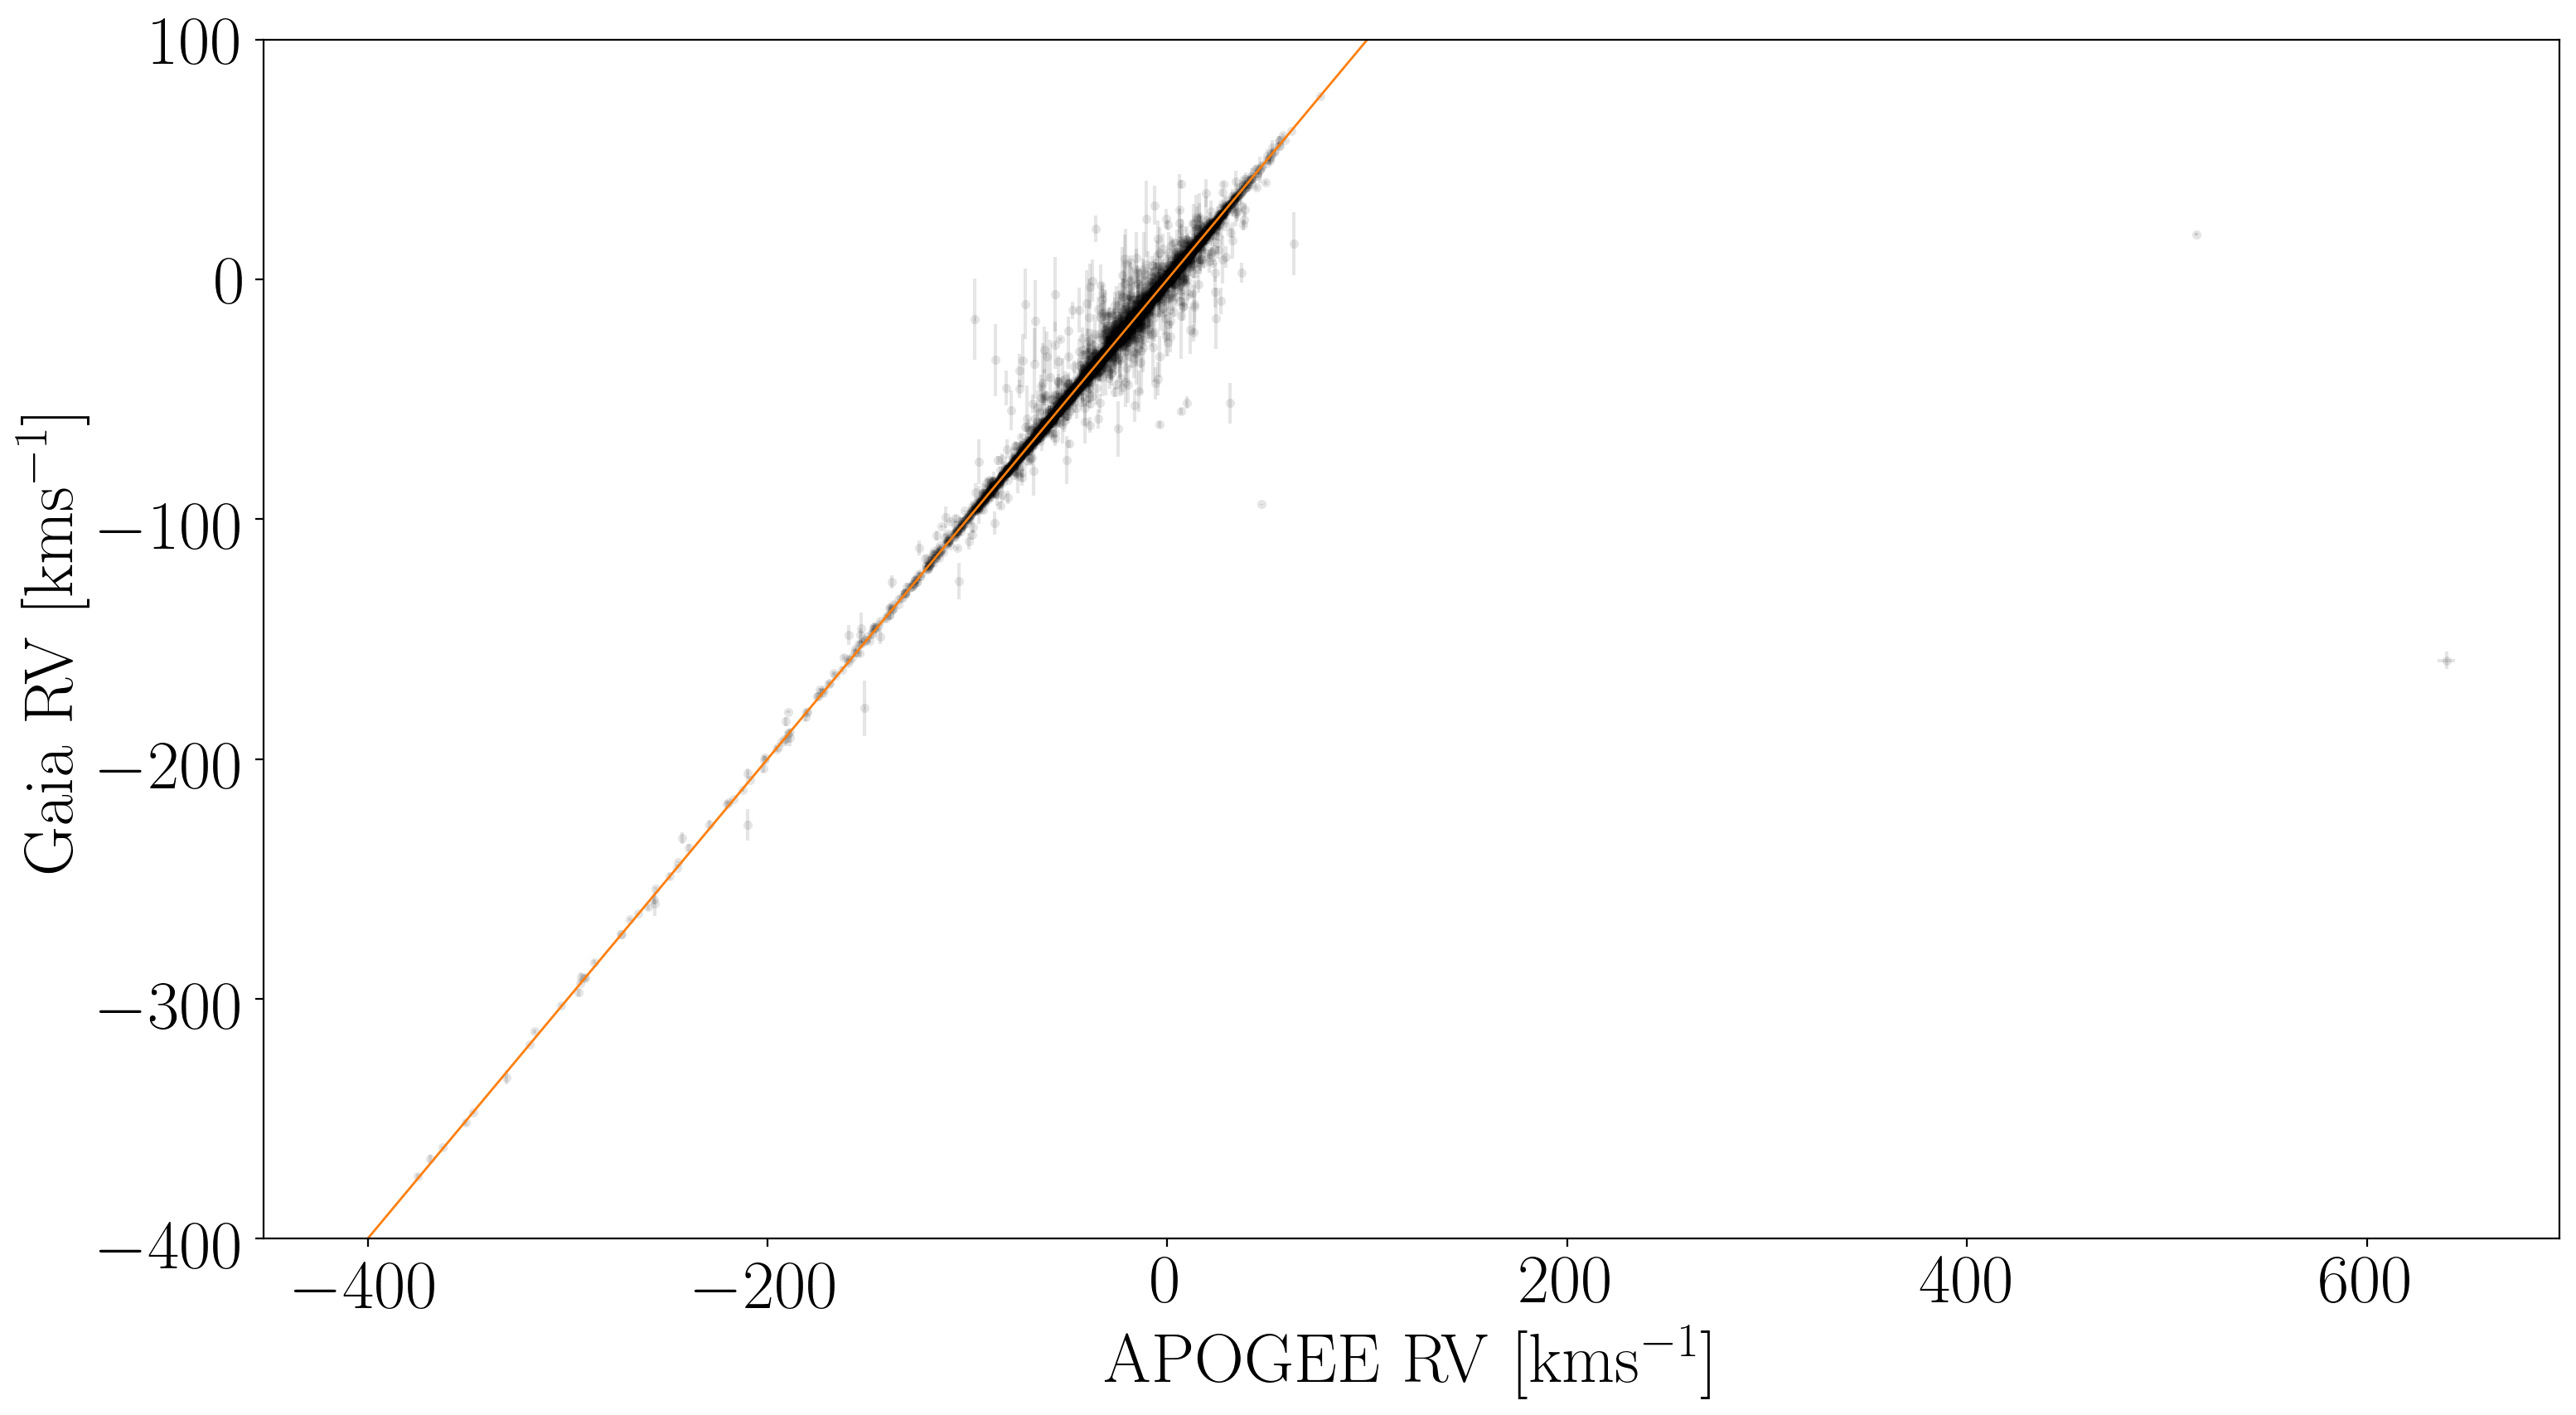

In [167]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.apogee_corrected_rv[mamg], df.radial_velocity.values[mamg],
             yerr=df.radial_velocity_error.values[mamg],
             xerr=df.OBSVERR.values[mamg],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.ylabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.xlabel("$\mathrm{APOGEE~RV~[km s^{-1}]}$")
plt.tight_layout()

1.6859233431448502 0.1518070756169501
1.7172992626413908 -0.022160516788074174


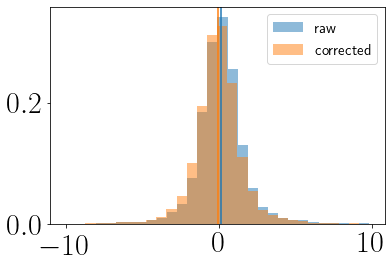

In [168]:
tot_err = np.sqrt(df.radial_velocity_error.values[mamg]**2 + df.OBSVERR.values[mamg]**2)
ro = abs(df.OBSVHELIO_AVG.values[mamg] - df.radial_velocity.values[mamg]) < 10 * tot_err

resids = df.radial_velocity.values[mamg][ro] - df.OBSVHELIO_AVG.values[mamg][ro]
resids2 = df.radial_velocity.values[mamg][ro] - df.apogee_corrected_rv.values[mamg][ro]
plt.hist(resids/tot_err[ro], 30, density=True, alpha=.5, label="raw");
print(np.std(resids/tot_err[ro]), np.mean(resids/tot_err[ro]))
plt.axvline(np.mean(resids/tot_err[ro]))

plt.hist(resids2/tot_err[ro], 30, density=True, alpha=.5, label="corrected");
print(np.std(resids2/tot_err[ro]), np.mean(resids2/tot_err[ro]))
plt.axvline(np.mean(resids2/tot_err[ro]), color="C1")

plt.legend()

# Here's one I made earlier

Load the file output by data.py

In [169]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")
print(np.shape(df))
df = df.drop_duplicates(subset="source_id")
print(np.shape(df))

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,20,21,22,28,30,54,55,56,74,76,155,156,176) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(178000, 350)
(177372, 350)


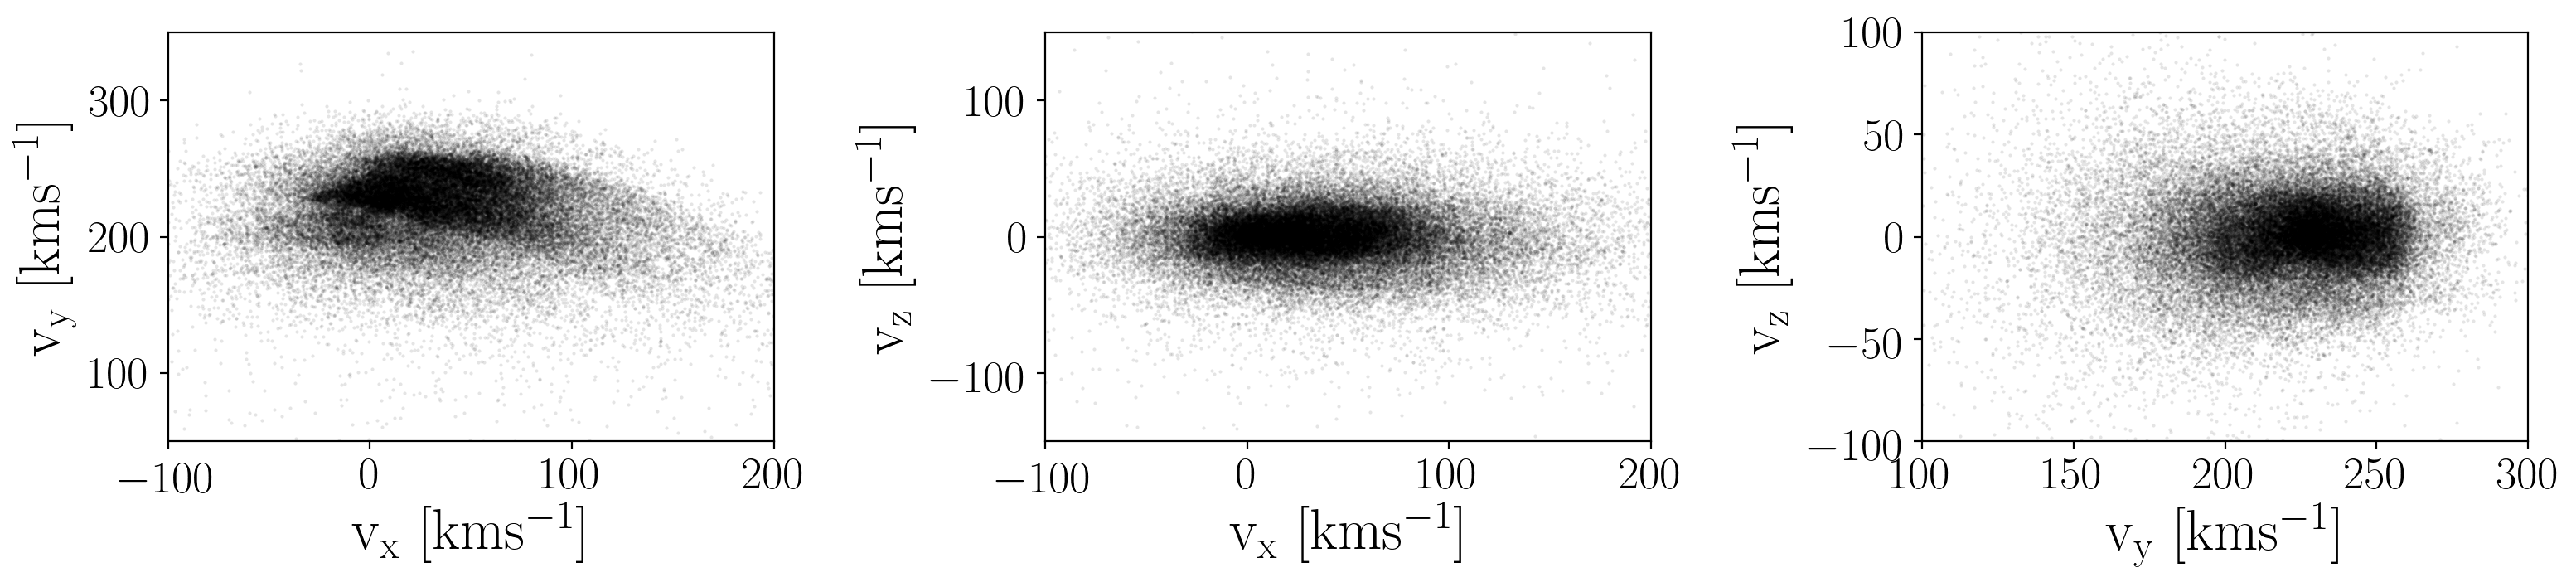

In [170]:
plotpar = {'axes.labelsize': 25,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(df.vx, df.vy, "k.", ms=1, alpha=.1, rasterized=True)
ax0.set_xlim(-100, 200)
ax0.set_ylim(50, 350)
ax0.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax0.set_ylabel("$\mathrm{v_y~[km s^{-1}]}$")

ax1 = fig.add_subplot(132)
ax1.plot(df.vx, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax1.set_xlim(-100, 200)
ax1.set_ylim(-150, 150)
ax1.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax1.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

ax2 = fig.add_subplot(133)
ax2.plot(df.vy, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax2.set_ylim(-100, 100)
ax2.set_xlim(100, 300)
ax2.set_xlabel("$\mathrm{v_y~[km s^{-1}]}$")
ax2.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

plt.tight_layout()

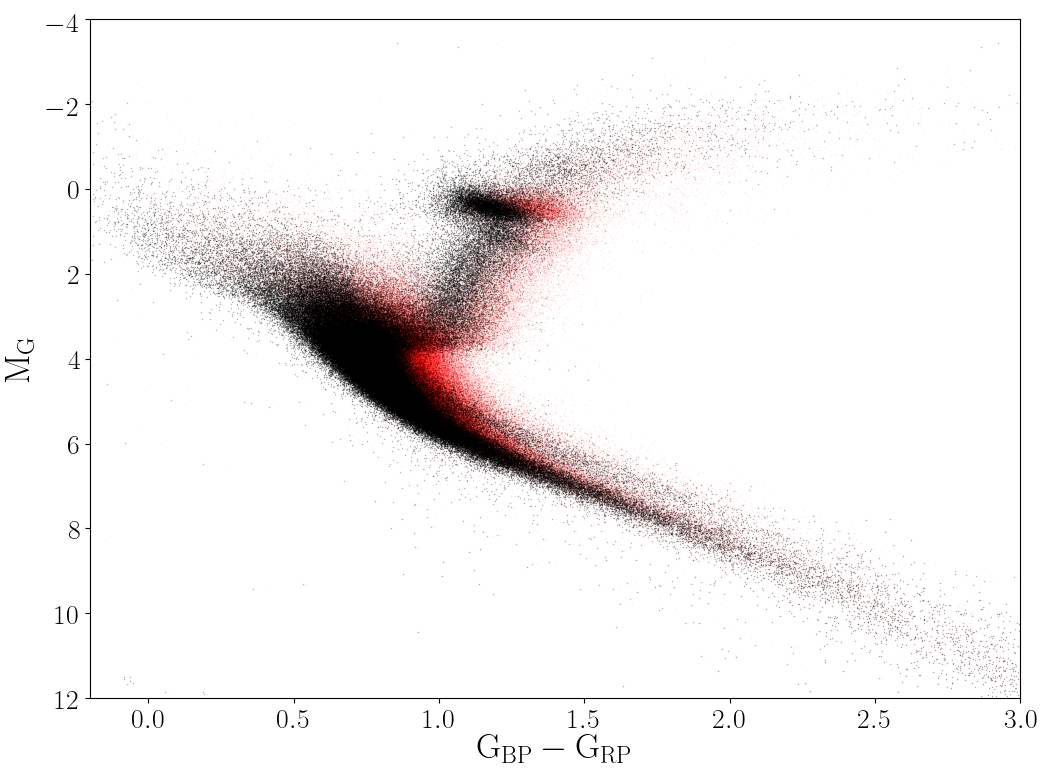

In [171]:
plt.figure(figsize=(12, 9), dpi=100)
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.abs_G, "r.", ms=2, alpha=.1, mec="none", zorder=0, rasterized=True)
plt.plot(df.bprp_dered, df.abs_G, "k.", ms=2, alpha=.3, mec="none", zorder=1)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

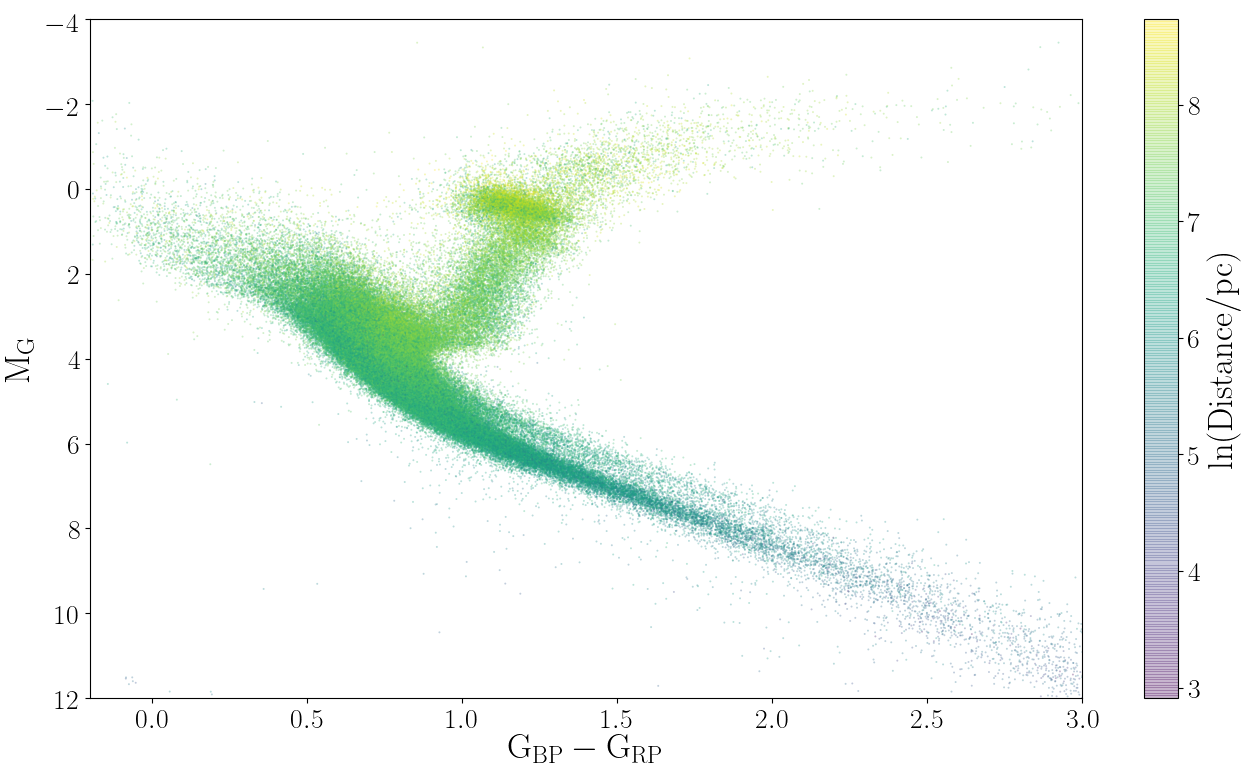

In [172]:
plt.figure(figsize=(16, 9), dpi=100)
plt.scatter(df.bprp_dered, df.abs_G, c=np.log(df.r_est), s=2, alpha=.3, edgecolor="none", zorder=1, rasterized=True)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.colorbar(label="$\ln(\mathrm{Distance/pc})$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

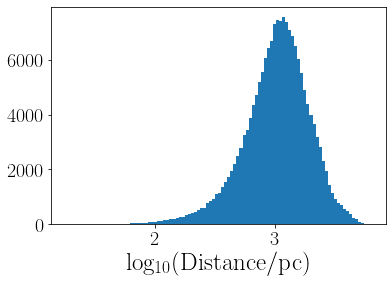

In [173]:
plt.hist(np.log10(df.r_est), 100);
plt.xlabel("$\mathrm{log_{10}(Distance/pc)}$");

# Look at the prior.

In [174]:
import starspot as ss

def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

lnD = np.log(1./df.parallax)
finite = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) \
    & np.isfinite(df.vz.values) & np.isfinite(lnD)

nsigma = 3
mx = ss.sigma_clip(df.vx.values[finite], nsigma=nsigma)
my = ss.sigma_clip(df.vy.values[finite], nsigma=nsigma)
mz = ss.sigma_clip(df.vz.values[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

mu, cov = mean_and_var(df.vx.values[finite][m],
                       df.vy.values[finite][m],
                       df.vz.values[finite][m],
                       lnD[finite][m])

print(np.shape(cov))

(4, 4)


In [175]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [176]:
# cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])

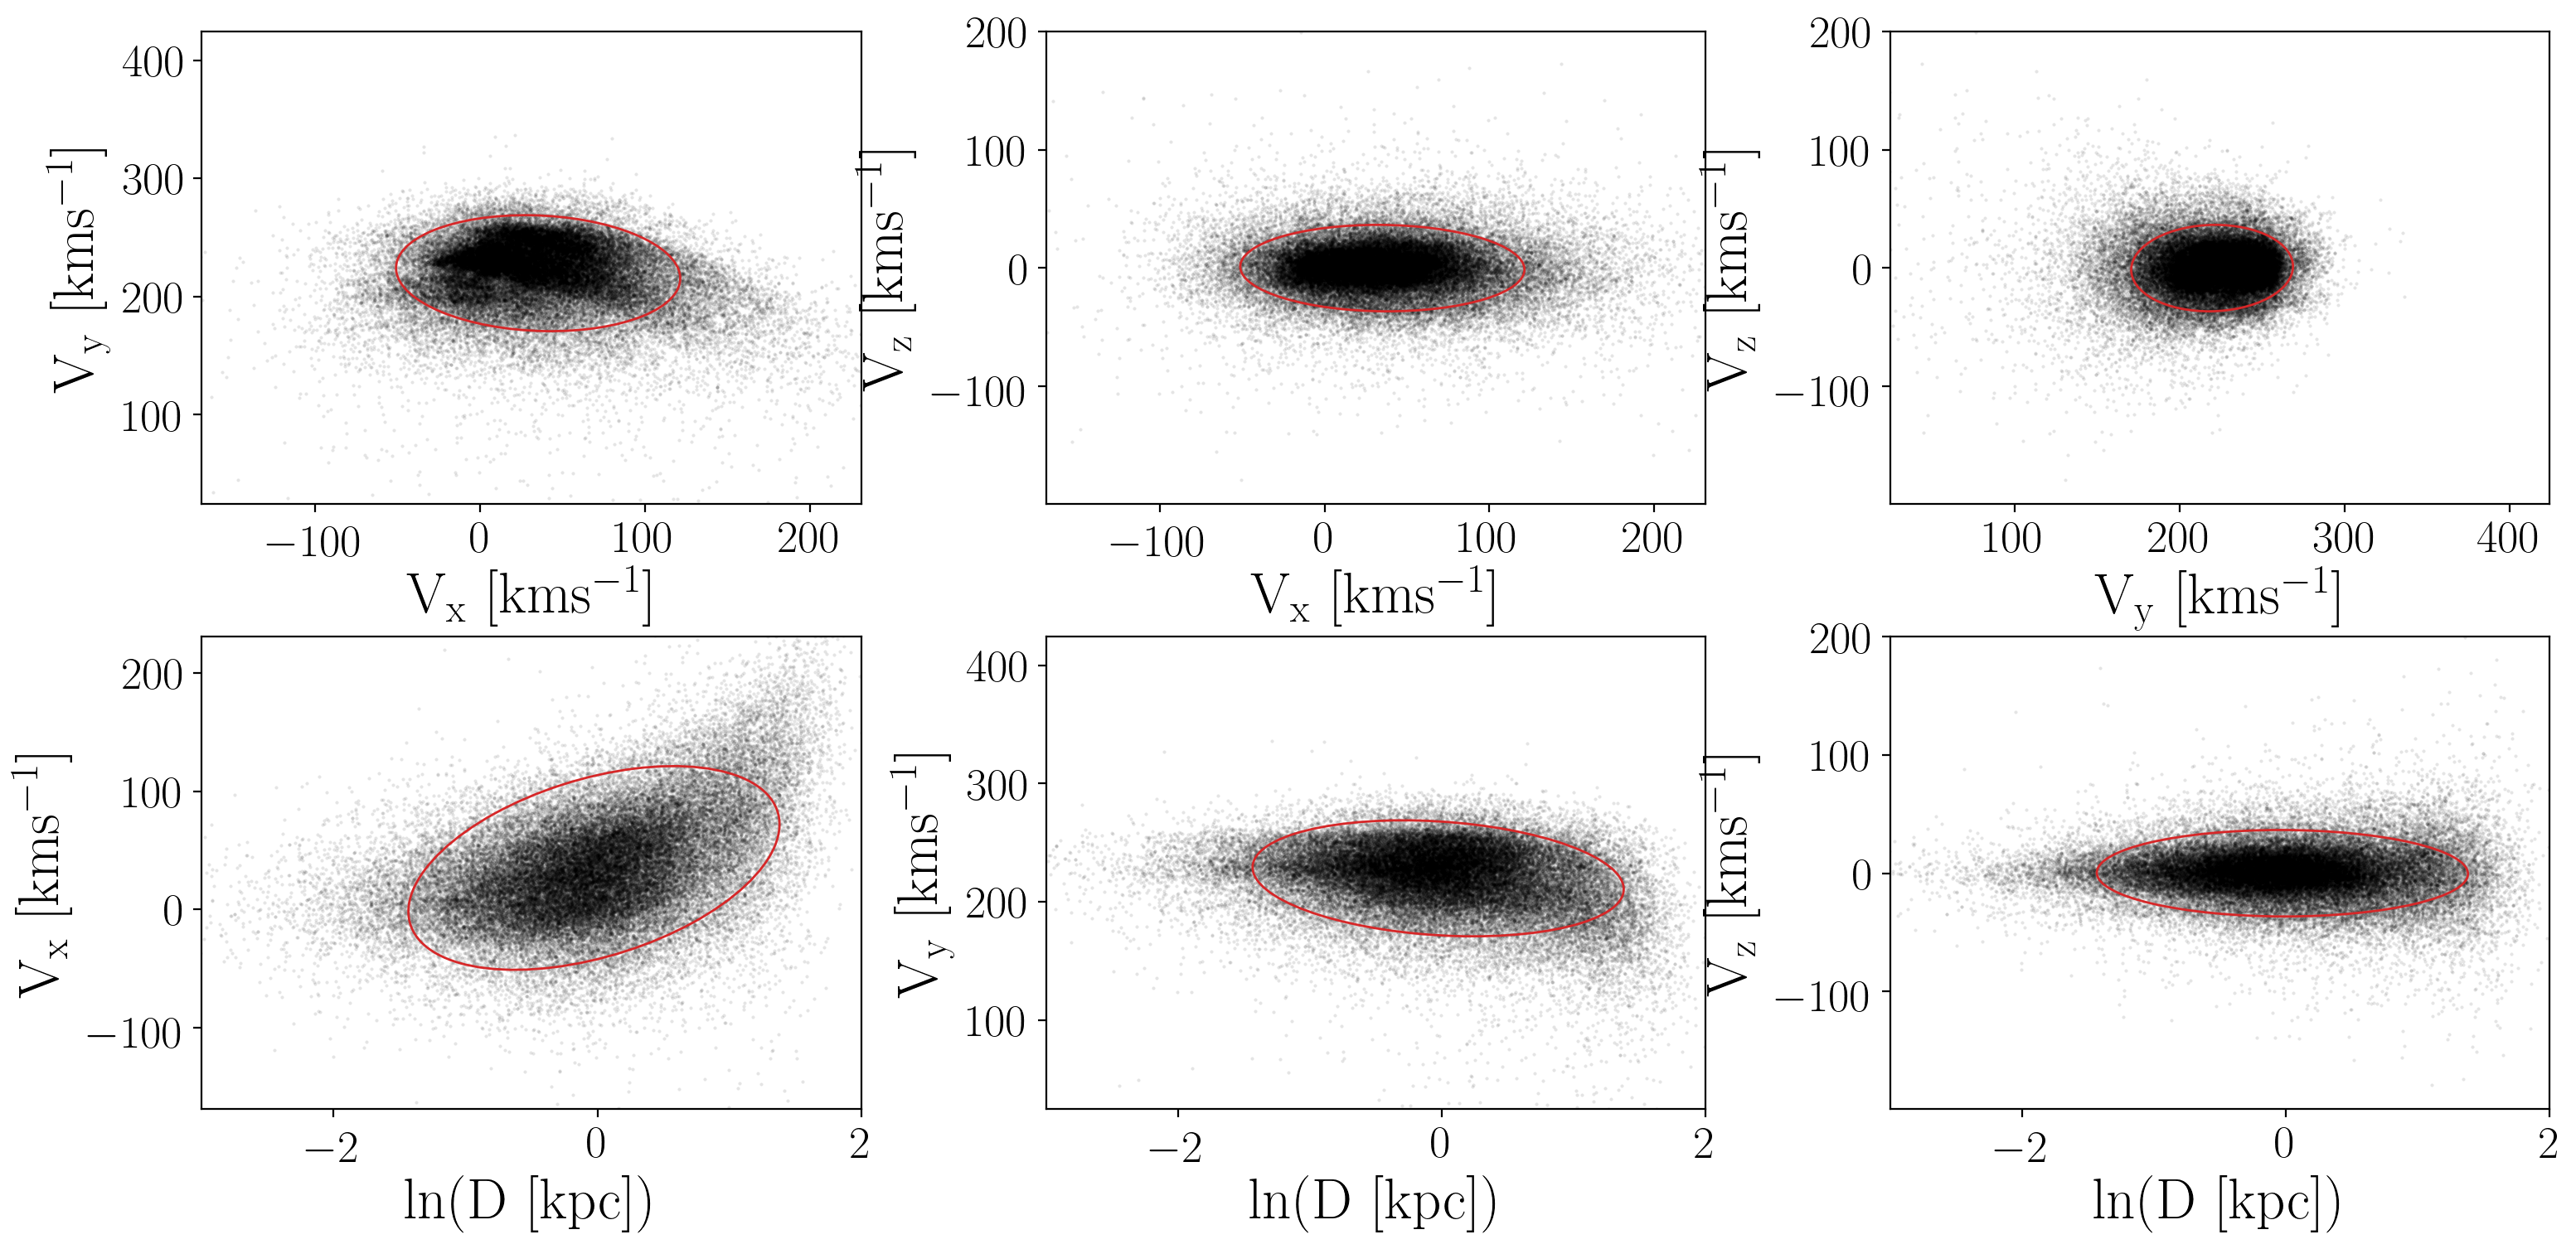

In [177]:
alpha, ms = .1, 1
color = "C3"

box = 200
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx_c, vy_c, vz_c, lnD_c = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.plot(vx_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.plot(lnD_c, vx_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.plot(lnD_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.28)

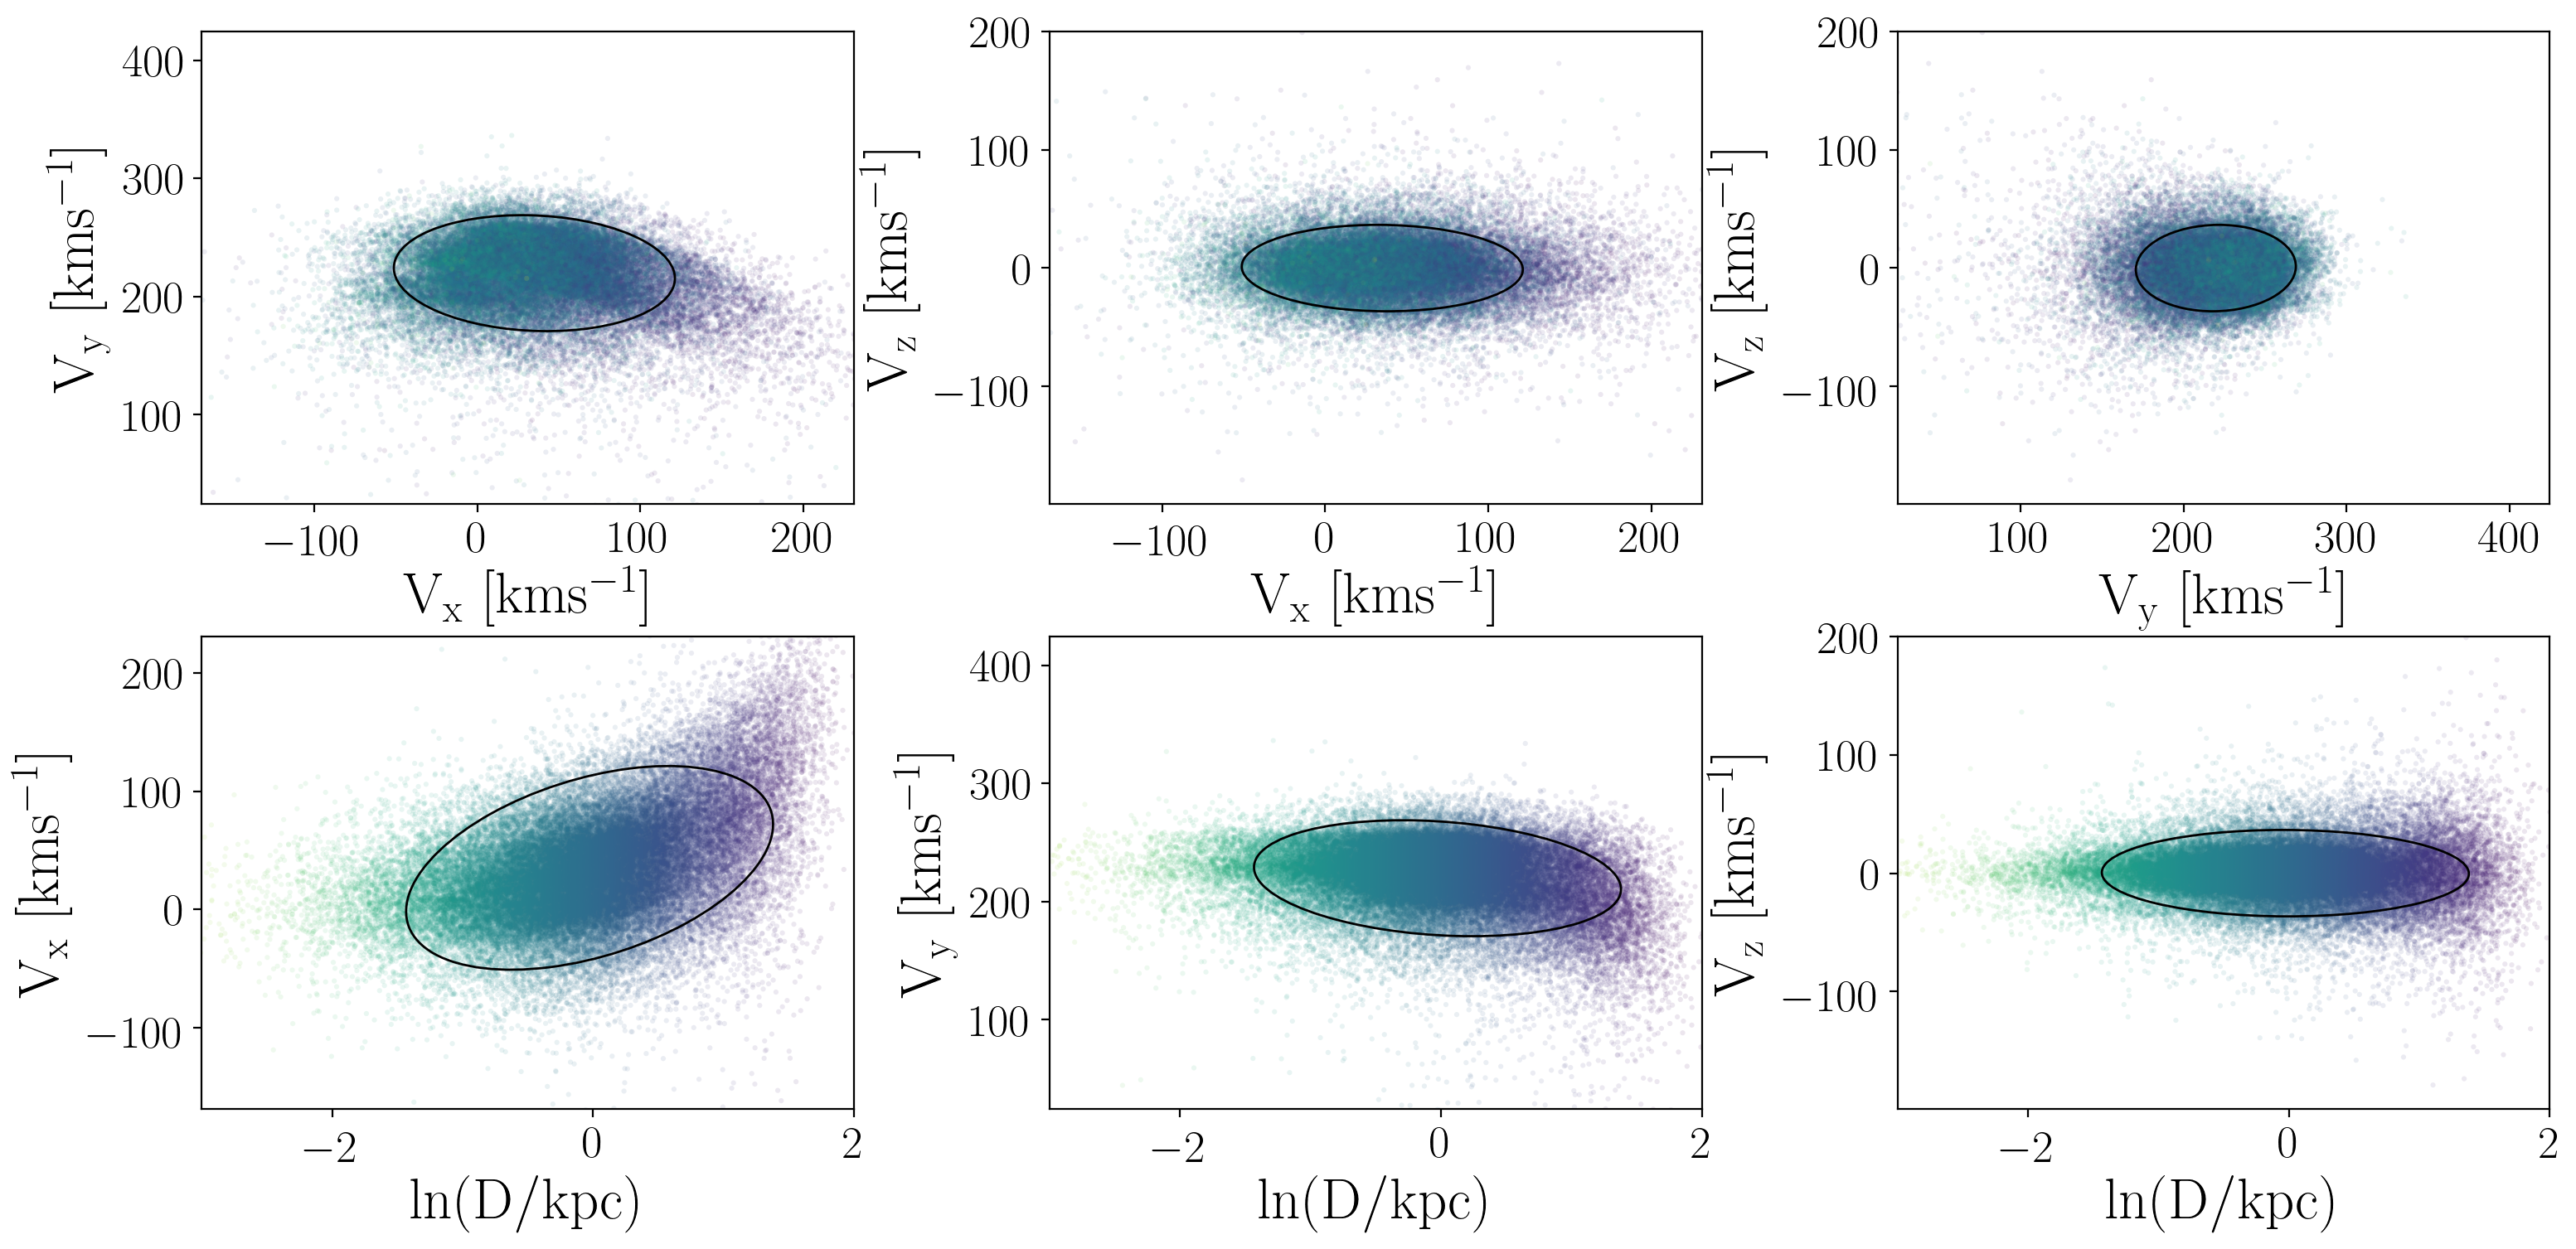

In [178]:
alpha, ms = .1, 1
color = "k"
cmap = "viridis_r"

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.scatter(vx_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.scatter(vx_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.scatter(vy_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.scatter(lnD_c, vx_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.scatter(lnD_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.scatter(lnD_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

# plt.colorbar()
plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.3)

54553 122819


Text(0.5, 0, 'Distance [pc]')

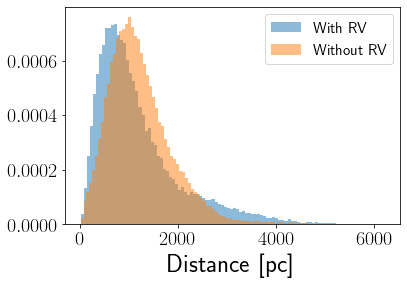

In [179]:
wrv = np.isfinite(df.rv.values) & (df.rv.values != 0)
print(len(df.r_est.values[wrv]), len(df.r_est.values[~wrv]))
plt.hist(df.r_est.values[wrv], 100, density=True, alpha=.5, label="With RV");
plt.hist(df.r_est.values[~wrv], 100, density=True, alpha=.5, label="Without RV");
plt.legend()
# plt.xlim(0, 10)
plt.xlabel("Distance [pc]")